# VECTORIZED HDC METHOD

In [1]:
# Import Basic Packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import string
import time
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from nltk import sent_tokenize,word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import *
from tabulate import tabulate
from os import listdir

## Data Insights and Pre-Processing

In [2]:
### Function: Collects sample data from files in Stanford Dataset Subfolders
    ## Inputs: folderpath: Path to Desired Folder
    ##         sentiment:  Sentiment Value (0 or 1)
    ## Output: df: Pandas Dataframe of all Sample Data found in desired folder
def stanfordDatasetFolderDataLoader(folderpath, sentiment):
    file_list=listdir(folderpath)

    df = pd.DataFrame(columns = ['Review', 'Sentiment'])
    for file in file_list:
        filepath=folderpath + file
        f = open(filepath,'r', encoding="utf-8")
        sample = f.read()
        f.close()
        df = df.append({'Review' : sample, 'Sentiment' : sentiment}, ignore_index = True)
    return df

# Choose Dataset (0: Sentiment140, 1: Stanford IMBD Dataset)
dataset = 0

# Load Dataset
if (dataset==0):
    print('Using Sentiment140 Twitter Dataset...')
    # Read in Sentiment140 data from CSV
    df = pd.read_csv('./Sentiment140_Tweets/data.csv')
    df.columns =['Sentiment', 'IDs', 'Date', 'Flag', 'User', 'Tweet']
else:
    print('Using Stanford IMBD Movie Review Dataset...')
    # Read in Training Stanford IMBD Movie Review data from subfolders
    train_pos=stanfordDatasetFolderDataLoader('./StanfordMovie/train/pos/',1)
    train_neg=stanfordDatasetFolderDataLoader('./StanfordMovie/train/neg/',0)
    train_df=pd.concat([train_pos, train_neg], axis=0)
    
    # Read in Testing Stanford IMBD Movie Review data from subfolders
    test_pos=stanfordDatasetFolderDataLoader('./StanfordMovie/test/pos/',1)
    test_neg=stanfordDatasetFolderDataLoader('./StanfordMovie/test/neg/',0)
    test_df=pd.concat([test_pos, test_neg], axis=0)

    df=pd.concat([train_df, test_df], axis=0)
print('Total number of Samples In Dataset:', len(df))

Using Sentiment140 Twitter Dataset...
Total number of Samples In Dataset: 1599999


In [3]:
# Dataset Cleanup:

# Sentiment140 Sentiment Clean Up
if dataset==0:
    # Replace Sentiment of 4 (Positive) with 1
    df["Sentiment"].replace({4: 1}, inplace=True)
    # Eliminate Neutral Tweets, if any
    df = df[df['Sentiment'] != 2]

# Check for Null Values
if ( not df.isnull().values.any() ):
    print("Dataset in Use has No NULL values.")
else:
    df.dropna(inplace=True)

print("Dataset Length after Cleanup:", len(df))

Dataset in Use has No NULL values.
Dataset Length after Cleanup: 1599999


In [4]:
# Downsample the Dataset to 5,000 Total Samples
if (dataset==0):
    percentage = 0.003125
else:
    percentage = 0.1
df_downsampled = df.sample(frac=percentage,random_state=0)
df_downsampled

,Sentiment,IDs,Date,Flag,User,Tweet
1016244,1,1881672289,Fri May 22 05:16:44 PDT 2009,NO_QUERY,viry_trivium,"Happy birthday, sister!"
1303317,1,2009051656,Tue Jun 02 15:04:22 PDT 2009,NO_QUERY,Earlthedog,Just finished eating supper and now I am attac...
576684,0,2211886069,Wed Jun 17 13:24:27 PDT 2009,NO_QUERY,StefyyMarie,i hate love right now.
837327,1,1558734942,Sun Apr 19 09:15:07 PDT 2009,NO_QUERY,tezzer57,"Photo fest in LDN, Tudor feast last night, don..."
985344,1,1834470136,Mon May 18 03:03:30 PDT 2009,NO_QUERY,dave_sherratt,"@piercedbrat happy bday for tomoz, all the bes..."
...,...,...,...,...,...,...
1369789,1,2050886442,Fri Jun 05 19:28:18 PDT 2009,NO_QUERY,thaisprudencio,today was awesome!
587089,0,2216194514,Wed Jun 17 19:09:39 PDT 2009,NO_QUERY,alwyshoutashley,I wish it would stop raining. I'm ready for th...
46597,0,1677444411,Sat May 02 02:06:29 PDT 2009,NO_QUERY,kasey79,@DannyGirlAlways Ok I still feel kind of bad t...
1409132,1,2055829198,Sat Jun 06 10:01:49 PDT 2009,NO_QUERY,Bockman13,Hanging with Anna and Fernando!


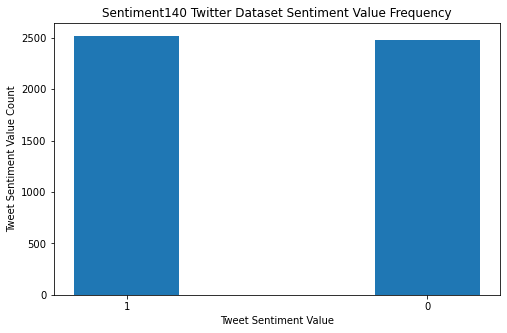

Where Sentiment is Positive when Sentiment Value = 1 and Negative when Sentiment Value = 0


In [5]:
# Visualization of Dataset Sentiment Outcomes - Ensured Even Distribution of Outcomes
sent_count = df_downsampled['Sentiment'].value_counts()
plt.figure(figsize=(8, 5))
w = 0.35  
plt.bar(x=np.arange(len(sent_count)), height=sent_count, width = w)
plt.xticks(np.arange(len(sent_count)), sent_count.index.tolist())

if dataset==0:
    plt.xlabel('Tweet Sentiment Value')
    plt.ylabel('Tweet Sentiment Value Count')
    plt.title('Sentiment140 Twitter Dataset Sentiment Value Frequency')
else:
    plt.xlabel('Movie Review Sentiment Value')
    plt.ylabel('Movie Review Sentiment Value Count')
    plt.title('Stanford IMBD Movie Review Dataset Sentiment Value Frequency')
plt.show()
print('Where Sentiment is Positive when Sentiment Value = 1 and Negative when Sentiment Value = 0')

In [6]:
### Function: Pre-Processes Samples
    ## Inputs: samples:        Array of samples
    ##         sample_results: Sentiment of Input Samples
    ## Outputs: pre_procc_samps: Array of samples pre-processed
    ##          pre_procc_res:   Array of results for pre-processed samples      
def PreProcess(samples, sample_results):
    pre_procc_samps = []
    pre_procc_res=[]

    # Storing all punctuations using RE library like !;,"% etc
    re_puncs = re.compile('[%s]' % re.escape(string.punctuation))
    # Storing all stop words like a, an, the, when, there, this etc
    stop_word  = set(stopwords.words('english'))
    # Lemmatizing object
    lem = WordNetLemmatizer()

    index=0
    for sample in samples:
        
        # Get rid or URLs and Twitter Handles
        sample = re.sub(r"http\S+", "", sample)
        sample = re.sub(r"@\S+", "", str(sample))

        # Get words in sample
        words = word_tokenize(str(sample))

        # Converting all characters to lower case
        words_lower = [w.lower() for w in words]              

        # Remove all punctuation
        words_lower_no_punc = [re_puncs.sub('', w) for w in words_lower]

        # Keep only alpha words
        words_lower_alpha = [i for i in words_lower_no_punc if i.isalpha()]

        # Removing all stop words
        words_lower_alpha_nostop = [w for w in words_lower_alpha if w not in stop_word]

        # Doing Lemmatizing of words
        words_lower_alpha_nostop_lemma = [lem.lemmatize(w) for w in words_lower_alpha_nostop]

        # Convert back to string and (possibly) one-hot encode tweet
        pre_procc_str = ' '.join(words_lower_alpha_nostop_lemma)
        if (pre_procc_str != ""):
            pre_procc_samps.append(pre_procc_str)
            pre_procc_res.append(sample_results[index])
        index=index+1
        
    return pre_procc_samps, pre_procc_res

# Pre-Proccess the Dataset
if dataset==0:
    Xdf, Ydf = PreProcess(df_downsampled['Tweet'].to_numpy(), df_downsampled['Sentiment'].to_numpy())
else:
    Xdf, Ydf = PreProcess(df_downsampled['Review'].to_numpy(), df_downsampled['Sentiment'].to_numpy())

# Get Final Train/Test Sets:
TrainXdf,TestXdf, TrainYdf, TestYdf = train_test_split(Xdf, Ydf, test_size=.3, random_state=2)
TrainYdf=np.array(TrainYdf)
TestYdf=np.array(TestYdf)
TrainXdf[1:5]

['sorry always going bed bye',
 'gon na fix nail polish auditorium isnt best place paint nail riding berts brei',
 'watch end season see think need rewatch season get',
 'fail stop writing ray bradbury lt love quote']

## Pre-Training Initialization
### Item Memory Function

In [7]:
### Function: Item Memory Generation
    ## Inputs: dim: Number of columns (i.e. length of HV)
    ##         num_char: Number of rows (i.e. number of features)
    ## Output: dictMem: Item Memory containing HVs for each supported char
def itemMemGen(dim=10000, num_char=37):
    dictMem = np.random.randint(2, size=(num_char, dim), dtype='int32')
    dictMem[dictMem == 0] = -1
    return dictMem

# Parameters:
HV_dim = 10000

### Training Functions

In [8]:
### Function: Encodes a Sample into a HV using VECTORIZED HDC Approach
    ## Inputs: sample:      Training Sample
    ##         itemMem:     Generate Item Memory
    ## Output: sample_HV: HV of inputted sample 
def encode(sample, itemMem):
    return sample.dot(itemMem)

### Function: VECTORIZED HDC Training Function that creates an Associative Memory for the Model
    ## Inputs: X:           Training Samples
    ##         Y:           Outputs of Training Samples
    ##         itemMem:     Generated Item Memory
    ##         HV_dim:      Dimension of HV
    ##         sent_count:  Number of Possible Sentiment Values
    ## Output: assocMem: Associative Memory 
def train(X, Y, itemMem, HV_dim, sent_count):
    assocMem = np.zeros((sent_count, HV_dim), dtype='int32')
    sample_idx = 0
    
    for sample in X:
        review_HV = encode(sample, itemMem)
        assocMem[Y[sample_idx]] = np.add(assocMem[Y[sample_idx]], review_HV)
        sample_idx += 1

    return assocMem

### Testing Functions

In [9]:
### Function: Compares Input HV to Class HVs and Returns the Predicted Class
    ## Inputs: assocMem: Model's Associative Memory
    ##         inputHV:  Encoded HV of a sample
    ## Output: pred: the predicted class
def get_prediction(assocMem, inputHV):
    pred = assocMem[0]
    maximum = np.NINF

    for index in range(len(assocMem)):
        similarity = cosine_similarity([inputHV, assocMem[index]])[0][1]  
        if (similarity > maximum):
            pred = index
            maximum = similarity

    return pred

### Function: Tests the VECTORIZED HDC Model and Returns Accuracy of Model
    ## Inputs: itemMem:     Generated Item Memory
    ##         assocMem:    Model's Associative Memory
    ##         TestXdf:     Test Samples
    ##         TextYdf:     Sentiment of Test Samples
    ## Output: accuracy: Accuracy of the Model
def test(itemMem, assocMem, TestXdf, TestYdf):
    correct_count = 0

    for index in range(len(TestXdf)):
        prediction = get_prediction(assocMem, encode(TestXdf[index], itemMem))
        if (TestYdf[index] == prediction):
            correct_count += 1
            
    accuracy = (correct_count / len(TestYdf)) * 100
    return accuracy

## Optimal Hyperparameter Search
### One-Shot Training/Accuracy of Various Sets of Hyperparameter Values

In [10]:
# Hyperparameters
vector_types = [0, 1, 2] # 0 for COUNT VECTOR, 1 for BINARY COUNT VECTOR, 2 for NORMALIZED COUNT VECTOR(tf-idf)
max_features = [300, 500, 700, 800, 900]
ngram_types = [(1,1), (2,2), (3,3), (1,2), (1,3)] # (1,1) for UNIGRAMS, (2,2) for BIGRAMS, (3,3) for TRIGRAMS, (1,2) for (UNIGRAMS,BIGRAMS), (1,3) for (UNIGRAMS,TRIGRAMS) 

# Optimal Result Initialization
best_acc=0
vector_type_best=0
max_feature_best=0
ngram_type_best=0
best_assocMem=[]
itemMem_best=[]
Train_best=[]
Test_best=[]

# Generate Item Memories Once for Each Max Features Option
ItemMem_300, ItemMem_500, ItemMem_700, ItemMem_800, ItemMem_900=[], [], [], [], []
for feat_num in max_features:
    if feat_num==300:
        ItemMem_300 = itemMemGen(dim=HV_dim, num_char=feat_num)
    elif feat_num==500:
        ItemMem_500 = itemMemGen(dim=HV_dim, num_char=feat_num)
    elif feat_num==700:
        ItemMem_700 = itemMemGen(dim=HV_dim, num_char=feat_num)
    elif feat_num==800:
        ItemMem_800 = itemMemGen(dim=HV_dim, num_char=feat_num)
    elif feat_num==900:
        ItemMem_900 = itemMemGen(dim=HV_dim, num_char=feat_num)

# Generate Table Initialization
table_data=[]
col_names = ["VECTOR TYPE", "MAX FEATURES", "NGRAM", "ONE-SHOT ACCURACY", "TRAINING TIME (s)", "NUMBER OF TRAINING SAMPLES", "TESTING TIME (s)", "NUMBER OF TESTING SAMPLES"]

for vector_type in vector_types:
    for max_feat in max_features:
        
        # Set ItemMem to Proper Generated ItemMeme
        if max_feat==300:
            itemMem = ItemMem_300
        elif max_feat==500:
            itemMem = ItemMem_500
        elif max_feat==700:
            itemMem = ItemMem_700
        elif max_feat==800:
            itemMem = ItemMem_800
        elif max_feat==900:
            itemMem = ItemMem_900

        for ngram in ngram_types:
            
            # Build Vectorizer With Desired Hyperparameters
            if (vector_type==0):
                cnt = CountVectorizer(analyzer="word", ngram_range=ngram, max_features=max_feat)
            elif(vector_type==1):
                cnt = CountVectorizer(analyzer="word", ngram_range=ngram, max_features=max_feat, binary=True)
            elif (vector_type==2):
                cnt = TfidfVectorizer(analyzer="word", ngram_range=ngram, max_features=max_feat) 
            
            # Fit Vectorizer and Transform Training/Testing Sets
            TrainXdf_temp = cnt.fit_transform(TrainXdf).toarray()
            TestXdf_temp = cnt.transform(TestXdf).toarray()

            # Train Model (i.e. Generate Model's Associative Memory)
            t0=time.time()
            assocMem = train(TrainXdf_temp, TrainYdf, itemMem, HV_dim, len(sent_count))
            t1=time.time()
            train_time = t1-t0

            # One-Shot Training Results
            t0=time.time()
            one_shot_accuracy=test(itemMem, assocMem, TestXdf_temp, TestYdf)
            t1=time.time()
            test_time = t1-t0

            # Add Data to Table
            data = [vector_type, max_feat, ngram, one_shot_accuracy, train_time, len(TrainYdf), test_time, len(TestYdf)]
            table_data.append(data)

            if one_shot_accuracy>best_acc:
                best_acc=one_shot_accuracy
                best_assocMem=assocMem
                itemMem_best=itemMem
                Train_best=TrainXdf_temp
                Test_best=TestXdf_temp
                
                cnt_best=cnt
                vector_type_best=vector_type
                max_feature_best=max_feat
                ngram_type_best=ngram

# Get Necessary Components for Best Model
assocMem=best_assocMem
itemMem=itemMem_best
TrainXdf=Train_best
TestXdf=Test_best

# Save Results to File
df=pd.DataFrame(table_data, columns=col_names)
filepath="./Results/HyperparameterResults/VECTORIZED_" + str(dataset) +".csv"
df.to_csv(filepath)
            
print("Results of Various Hyperparameter Sets:")
print(tabulate(table_data, headers=col_names, tablefmt="simple"))
print("\nVector Type Key: 0 for COUNT VECTOR, 1 for BINARY COUNT VECTOR, 2 for NORMALIZED COUNT VECTOR(tf-idf)")
print("NGRAM Key: 1 for UNIGRAMS, 2 for BIGRAMS, 3 for TRIGRAMS, (1,2) for (UNIGRAMS & BIGRAMS), (1,3) for (UNIGRAMS,BIGRAMS, & TRIGRAMS)\n")
print("Best Hyperparameters: VECTOR TYPE: ", vector_type_best, ", MAX FEATURES: ", max_feature_best, ", NGRAM: ", ngram_type_best)
print("Best One-Shot Accuracy: ", best_acc)

Results of Various Hyperparameter Sets:
  VECTOR TYPE    MAX FEATURES  NGRAM      ONE-SHOT ACCURACY    TRAINING TIME (s)    NUMBER OF TRAINING SAMPLES    TESTING TIME (s)    NUMBER OF TESTING SAMPLES
-------------  --------------  -------  -------------------  -------------------  ----------------------------  ------------------  ---------------------------
            0             300  (1, 1)               64.7256              57.1328                          3484             28.2679                         1494
            0             300  (2, 2)               51.004               58.8768                          3484             28.0999                         1494
            0             300  (3, 3)               49.9331              56.7932                          3484             28.2333                         1494
            0             300  (1, 2)               64.3909              56.6563                          3484             28.6295                         1494


## Retraining Optimal Model

In [11]:
### Function: VECTORIZED HDC Re-Training Function that creates a New Associative Memory for the Model
    ## Inputs: X:           Training Samples
    ##         Y:           Outputs of Training Samples
    ##         itemMem:     Generated Item Memory
    ##         assocMem:    Associative Memory of Current Model
    ##         alpha:       Learning Rate Parameter
    ## Output: assocMem: New Associative Memory
def retrain(X, Y, itemMem, assocMem, alpha):
    sample_index = 0
    for sample in X:
        sample_HV = encode(sample, itemMem)
        prediction = get_prediction(assocMem, sample_HV)
        if prediction != Y[sample_index]:
            assocMem[Y[sample_index]] = np.add(assocMem[Y[sample_index]], alpha * sample_HV)
            assocMem[prediction] = np.subtract(assocMem[prediction], alpha * sample_HV)
        sample_index += 1
    return assocMem

# Re-Train Optimal Model
all_accuracies=[]
num_epochs = 20
print('-------- Retraining Model: ', num_epochs, ' Epochs --------')
for epoch in range(num_epochs):
    assocMem = retrain(TrainXdf, TrainYdf, itemMem, assocMem, alpha = num_epochs - epoch)
    acc = test(itemMem, assocMem, TestXdf, TestYdf)
    print('Epoch ', (epoch+1), ': ', acc)
    all_accuracies.append(acc)

# Save Results to File
filepath="./Results/EpochResults/VECTORIZED_" + str(dataset) + ".csv"
np.savetxt(filepath, np.array(all_accuracies), delimiter=',')

-------- Retraining Model:  20  Epochs --------
Epoch  1 :  63.31994645247657
Epoch  2 :  61.24497991967871
Epoch  3 :  61.31191432396251
Epoch  4 :  62.51673360107095
Epoch  5 :  62.58366800535475
Epoch  6 :  59.70548862115127
Epoch  7 :  62.44979919678715
Epoch  8 :  61.37884872824632
Epoch  9 :  61.31191432396251
Epoch  10 :  62.51673360107095
Epoch  11 :  61.64658634538153
Epoch  12 :  61.71352074966533
Epoch  13 :  61.57965194109772
Epoch  14 :  63.05220883534136
Epoch  15 :  62.784471218206164
Epoch  16 :  61.84738955823293
Epoch  17 :  63.31994645247657
Epoch  18 :  63.58768406961178
Epoch  19 :  62.65060240963856
Epoch  20 :  63.186077643908966
